In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from itertools import combinations
%matplotlib inline

In [2]:
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol.to_list()
timeframe = '5y'
start_cash = 10_000

In [3]:
df=yf.download(tickers, period=timeframe)['Close']

/var/folders/pc/lwrwx3mn1jq97mrd103w8tm80000gn/T/ipykernel_48306/896026501.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(tickers, period=timeframe)['Close']
[*********************100%***********************]  503 of 503 completed

2 Failed downloads:
['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y)')
['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=5y) (Yahoo error = "No data found, symbol may be delisted")')


In [4]:
def adftest(stock1, stock2, df):
    x = df[stock1].values
    x = sm.add_constant(x)
    y = df[stock2].values

    model = sm.OLS(y,x).fit()
    intercept, slope = model.params
    residuals = y - (intercept + slope*x[:,1])
    if np.isnan(residuals).any():
        return np.nan
    result = adfuller(residuals)
    return result[0], result[1], slope, intercept

In [5]:
def test_coint (df = df):

    combination_df = pd.DataFrame(combinations(df.columns,2))
    combination_df.columns = ['Stock1','Stock2']
    combination_df['Correlation'] = combination_df.apply(lambda row: np.corrcoef(df[row['Stock1']],df[row['Stock2']])[0,1],axis=1)
    combination_df = combination_df[combination_df['Correlation'] > 0.95]
    combination_df[['adf_stat','p-value','Slope','Intercept']] = combination_df.apply(lambda row: pd.Series(adftest(row['Stock1'], row['Stock2'],df)),axis=1)
    combination_df = combination_df[combination_df['p-value'] < 0.05]
    return combination_df


In [8]:
coint_df = test_coint()


In [23]:
coint_stocks = set(coint_df['Stock1'])

for stock in coint_stocks:
    if df[stock].iloc[-1]-df[stock].iloc[1] <= 0:
        print(stock)


PYPL
PSKY
EL
MTCH
CCI


In [ ]:
print(coint_df[coint_df['Stock1'] == 'PYPL'])

       Stock1 Stock2  Correlation  adf_stat   p-value     Slope  Intercept
119090   PSKY    WBD     0.966339 -2.949926  0.039843  0.881349  -1.608569


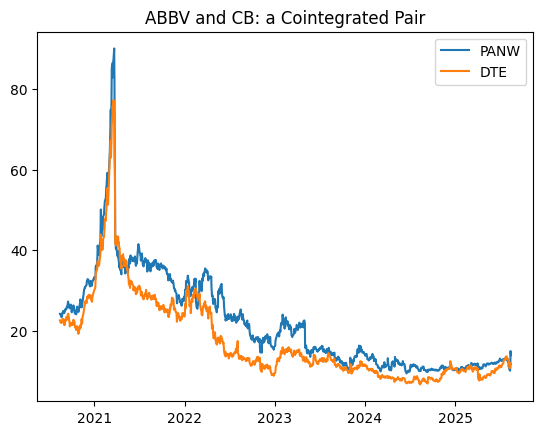

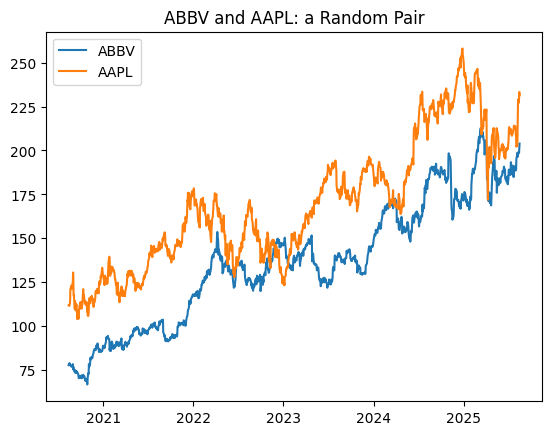

In [ ]:
import matplotlib.pyplot as plt
ticker1 = 'ABBV'
ticker2 = 'CB'
fig, ax = plt.subplots()
plt.title(f'{ticker1} and {ticker2}: a Cointegrated Pair')
ax.plot(df[ticker1], label = ticker1)
ax.plot(df[ticker2], label = ticker2)
ax.legend()


fig, ax = plt.subplots()
plt.title('ABBV and AAPL: a Random Pair')
ax.plot(df['ABBV'], label = 'ABBV')
ax.plot(df['AAPL'], label = 'AAPL')
ax.legend()


plt.show()


